# Heart Failure Prediction

https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

`Binary` classification task

__0__ - fatal outcome,

__1__ - without fatal outcome


    Popular algorithms that can be used for binary classification include:

- Logistic Regression,
- k-Nearest Neighbors,
- Decision Trees,
- Support Vector Machine,
- Naive Bayes

In [569]:
import warnings
from typing import Tuple, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve

In [570]:
# Loading the data
df = pd.read_csv('/Users/ekaterinamoskvina/Desktop/heart_failure_clinical_records_dataset.csv')

## <font color="red">__Step 1:__</font> 
Dataset Overview and data preprocessing

In [513]:
# Dataset Overview
df.sample(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
285,55.000,1,170,1,40,0,336000.0,1.2,135,1,0,250,0
67,72.000,1,110,0,25,0,274000.0,1.0,140,1,1,65,1
227,55.000,1,2794,0,35,1,141000.0,1.0,140,1,0,206,0
27,70.000,0,122,1,45,1,284000.0,1.3,136,1,1,26,1
187,60.000,0,1896,1,25,0,365000.0,2.1,144,0,0,172,1
36,90.000,1,60,1,50,0,226000.0,1.0,134,1,0,30,1
229,72.000,0,211,0,25,0,274000.0,1.2,134,0,0,207,0
56,70.000,1,75,0,35,0,223000.0,2.7,138,1,1,54,0
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172,0
237,70.000,0,232,0,30,0,173000.0,1.2,132,1,0,210,0


In [514]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [515]:
# number of observations and features (rows and columns)
df.size, df.shape

(3887, (299, 13))

In [279]:
# checking duplicated rows
df[df.duplicated()]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


In [280]:
# missing values per feature
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

<Axes: >

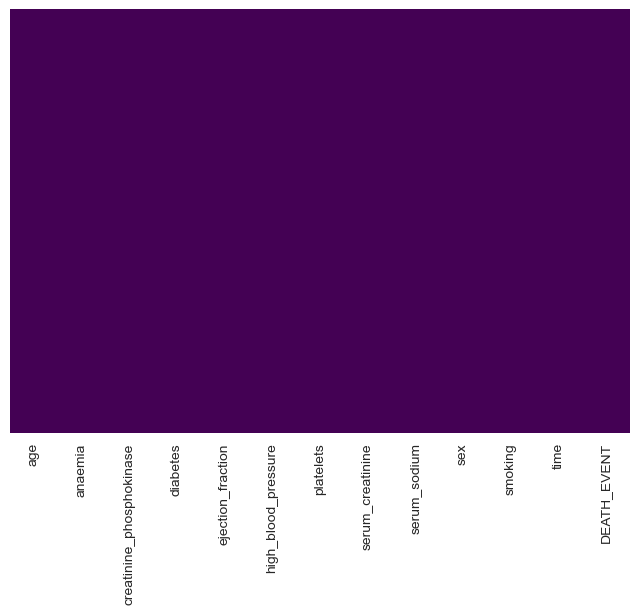

In [281]:
# another way to check missing values per feature
# Is there any variable with missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [282]:
# number of missing cells
df.isna().sum().sum()

0

In [283]:
# percentage of missing cells
round(df.isna().sum().sum() / df.size * 100,1)

0.0

In [284]:
# number of NaN values 
for i in df.columns:
    print(i, df[i][df[i]== 'NaN'].count())

age 0
anaemia 0
creatinine_phosphokinase 0
diabetes 0
ejection_fraction 0
high_blood_pressure 0
platelets 0
serum_creatinine 0
serum_sodium 0
sex 0
smoking 0
time 0
DEATH_EVENT 0


<font color="blue">__The dataset have two types of features:__</font>
- continuous,
- categorical(binary)

To apply `describe method` split a dataset into two: continuous_data and categorical_data_binary to analyze them separately. 

In [285]:
# Check columns for the number of unique values to identify columns with two unique values
print(df.nunique())

age                          47
anaemia                       2
creatinine_phosphokinase    208
diabetes                      2
ejection_fraction            17
high_blood_pressure           2
platelets                   176
serum_creatinine             40
serum_sodium                 27
sex                           2
smoking                       2
time                        148
DEATH_EVENT                   2
dtype: int64


In [340]:
df_for_splitting = df.copy()

In [200]:
# List 1
continuous_data = ['Age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

# List 2
categorical_data_binary = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'time', 'DEATH_EVENT']

list_of_tuples = list(zip(continuous_data,categorical_data_binary))
df_features = pd.DataFrame(list_of_tuples, columns=['Continuous_Data', 'Categorical(binary)_Data'])
df_features

,Continuous_Data,Categorical(binary)_Data
0,Age,anaemia
1,creatinine_phosphokinase,diabetes
2,ejection_fraction,high_blood_pressure
3,platelets,sex
4,serum_creatinine,smoking
5,serum_sodium,time


In [341]:
df_numerical = df_for_splitting[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']]
df_categorical = df_for_splitting[['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'time', 'DEATH_EVENT']]

In [342]:
df_categorical

,anaemia,diabetes,high_blood_pressure,sex,smoking,time,DEATH_EVENT
0,0,0,1,1,0,4,1
1,0,0,0,1,0,6,1
2,0,0,0,1,1,7,1
3,1,0,0,1,0,7,1
4,1,1,0,0,0,8,1
...,...,...,...,...,...,...,...
294,0,1,1,1,1,270,0
295,0,0,0,0,0,271,0
296,0,1,0,0,0,278,0
297,0,0,0,1,1,280,0


In [343]:
df_numerical

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,75.0,582,20,265000.00,1.9,130
1,55.0,7861,38,263358.03,1.1,136
2,65.0,146,20,162000.00,1.3,129
3,50.0,111,20,210000.00,1.9,137
4,65.0,160,20,327000.00,2.7,116
...,...,...,...,...,...,...
294,62.0,61,38,155000.00,1.1,143
295,55.0,1820,38,270000.00,1.2,139
296,45.0,2060,60,742000.00,0.8,138
297,45.0,2413,38,140000.00,1.4,140


In [290]:
df_numerical.describe().round()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,299.0,299.0,299.0,299.0,299.0,299.0
mean,61.0,582.0,38.0,263358.0,1.0,137.0
std,12.0,970.0,12.0,97804.0,1.0,4.0
min,40.0,23.0,14.0,25100.0,0.0,113.0
25%,51.0,116.0,30.0,212500.0,1.0,134.0
50%,60.0,250.0,38.0,262000.0,1.0,137.0
75%,70.0,582.0,45.0,303500.0,1.0,140.0
max,95.0,7861.0,80.0,850000.0,9.0,148.0


### <font color="blue">Interpretation</font>

It can be observed that the maximum and minimum values of numerical features differs greatly from the 75% and 25% values, correspondingly. This may indicate the presence of outliers.

In [291]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   anaemia              299 non-null    int64
 1   diabetes             299 non-null    int64
 2   high_blood_pressure  299 non-null    int64
 3   sex                  299 non-null    int64
 4   smoking              299 non-null    int64
 5   time                 299 non-null    int64
 6   DEATH_EVENT          299 non-null    int64
dtypes: int64(7)
memory usage: 16.5 KB


__Because categorical data have integer values, convert them to object type to apply a describe() method__

In [292]:
df_categorical_object = df_categorical.astype(object)
df_categorical_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   anaemia              299 non-null    object
 1   diabetes             299 non-null    object
 2   high_blood_pressure  299 non-null    object
 3   sex                  299 non-null    object
 4   smoking              299 non-null    object
 5   time                 299 non-null    object
 6   DEATH_EVENT          299 non-null    object
dtypes: object(7)
memory usage: 16.5+ KB


In [293]:
df_categorical_object.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,time,DEATH_EVENT
count,299,299,299,299,299,299,299
unique,2,2,2,2,2,148,2
top,0,0,0,1,0,250,0
freq,170,174,194,194,203,7,203


In [294]:
# short code
df_categorical_object.astype(object).describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,time,DEATH_EVENT
count,299,299,299,299,299,299,299
unique,2,2,2,2,2,148,2
top,0,0,0,1,0,250,0
freq,170,174,194,194,203,7,203


### <font color="blue">Interpretation</font>

- __count:__ How many values in the columns.
- __unique:__ How many unique values in the columns.
- __top:__ The “top” value: 0 or 1.
- __freq:__ How often top value occurs 1 time.

__It is seen that a dataset has more values without DEATH_EVENT and it is positively correlated with the absence of anaemia, diabetes, high_blood_pressure, smoking, and female gender.__ Later it will be checked. 

## <font color="red">__Step 2:__</font> 

Feature Assessment and Visualization

In [344]:
for column in df.columns:
    data = df[column]

    # Shapiro-Wilk normality test
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        print(f'{column}: is NORMALLY distributed')
    else:
        print('--------------------------------------')
        print(f'{column}: is NOT normally distributed')

--------------------------------------
age: is NOT normally distributed
--------------------------------------
anaemia: is NOT normally distributed
--------------------------------------
creatinine_phosphokinase: is NOT normally distributed
--------------------------------------
diabetes: is NOT normally distributed
--------------------------------------
ejection_fraction: is NOT normally distributed
--------------------------------------
high_blood_pressure: is NOT normally distributed
--------------------------------------
platelets: is NOT normally distributed
--------------------------------------
serum_creatinine: is NOT normally distributed
--------------------------------------
serum_sodium: is NOT normally distributed
--------------------------------------
sex: is NOT normally distributed
--------------------------------------
smoking: is NOT normally distributed
--------------------------------------
time: is NOT normally distributed
--------------------------------------
DEAT

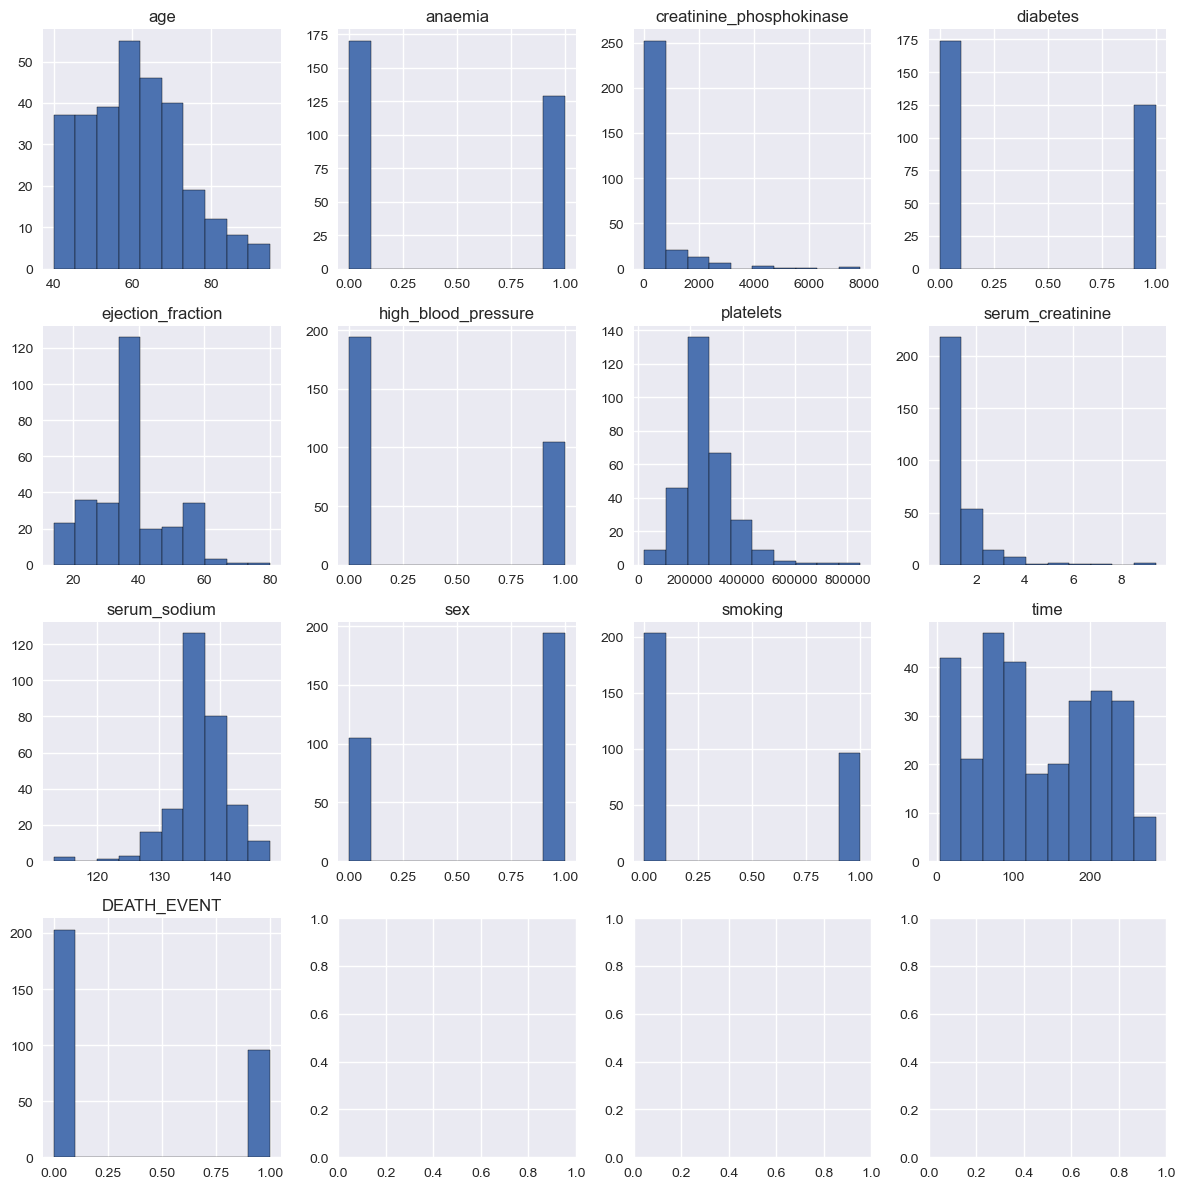

In [345]:
num_rows = 4
num_col = 4

fig, axes = plt.subplots(num_rows, num_col, figsize=(12,12))
for i, column in enumerate(df.columns):
    row = i // num_cols
    col = i % num_cols
    
    data = df[column]
    
    axes[row, col].hist(data, bins=10, edgecolor = 'black')
    axes[row, col].set_title(column)
    
plt.tight_layout()
plt.show()

### <font color="green">Verification of __Outliers__ </font> 

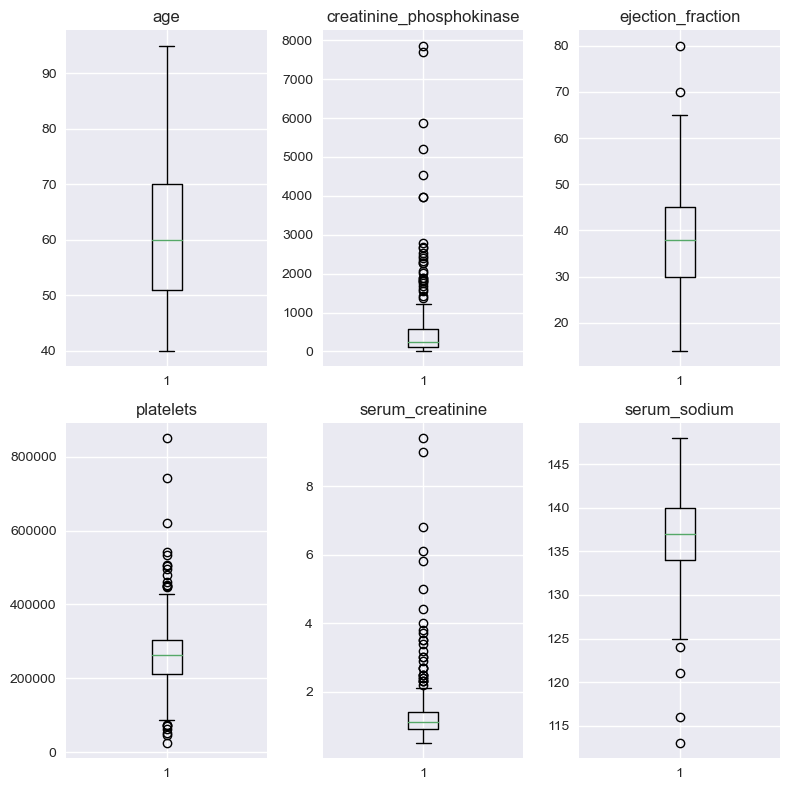

In [516]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

for i, ax in enumerate(axes.flatten()):
    ax.boxplot(df[features[i]])
    ax.set_title(features[i])

plt.tight_layout()
plt.show()

### <font color="blue">Interpretation</font>

Demonstration of the outliers beyond the first quartile and the third quartile in the box plots.  

__Because outliers can pose a significant threat to model performance, it’s important to handle them.__

In [571]:
df_wo_outliers_trim = df.copy()
df_wo_outliers_trim.sample(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
14,49.0,1,80,0,30,1,427000.0,1.0,138,0,0,12,0
276,70.0,0,618,0,35,0,327000.0,1.1,142,0,0,245,0
68,70.0,0,161,0,25,0,244000.0,1.2,142,0,0,66,1
169,70.0,0,835,0,35,1,305000.0,0.8,133,0,0,145,0
126,46.0,0,168,1,17,1,271000.0,2.1,124,0,0,100,1
197,65.0,0,167,0,30,0,259000.0,0.8,138,0,0,186,0
209,49.0,0,972,1,35,1,268000.0,0.8,130,0,0,187,0
106,55.0,0,748,0,45,0,263000.0,1.3,137,1,0,88,0
282,42.0,0,64,0,30,0,215000.0,3.8,128,1,1,250,0
215,73.0,0,582,0,35,1,203000.0,1.3,134,1,0,195,0


### TRIMMING

In [572]:
columns_to_clean = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

for column in columns_to_clean:
    Q1 = df_wo_outliers_trim[column].quantile(0.25)
    Q3 = df_wo_outliers_trim[column].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5
    outliers = df_wo_outliers_trim[(df_wo_outliers_trim[column] < Q1 - threshold * IQR) | (df_wo_outliers_trim[column] > Q3 + threshold * IQR)]
    df_wo_outliers_trim = df_wo_outliers_trim.drop(outliers.index)

for column in columns_to_clean:
    print(df_wo_outliers_trim[column])

0      582
2      146
3      111
5       47
6      246
      ... 
291    320
292    190
293    103
294     61
298    196
Name: creatinine_phosphokinase, Length: 224, dtype: int64
0      20
2      20
3      20
5      40
6      15
       ..
291    35
292    38
293    35
294    38
298    45
Name: ejection_fraction, Length: 224, dtype: int64
0      265000.0
2      162000.0
3      210000.0
5      204000.0
6      127000.0
         ...   
291    133000.0
292    382000.0
293    179000.0
294    155000.0
298    395000.0
Name: platelets, Length: 224, dtype: float64
0      1.9
2      1.3
3      1.9
5      2.1
6      1.2
      ... 
291    1.4
292    1.0
293    0.9
294    1.1
298    1.6
Name: serum_creatinine, Length: 224, dtype: float64
0      130
2      129
3      137
5      132
6      137
      ... 
291    139
292    140
293    136
294    143
298    136
Name: serum_sodium, Length: 224, dtype: int64


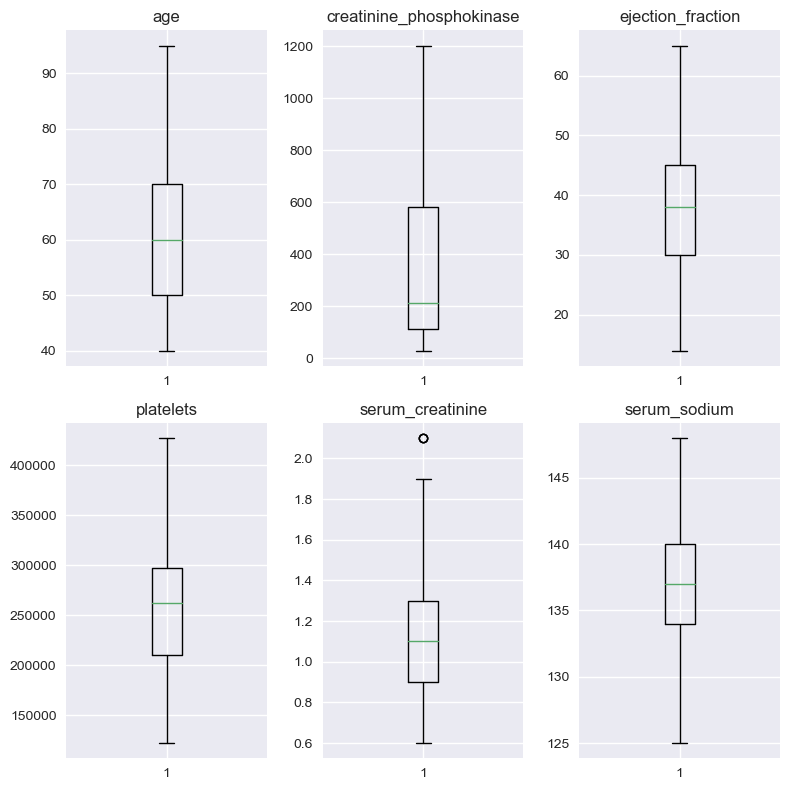

In [521]:
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

for i, ax in enumerate(axes.flatten()):
    ax.boxplot(df_wo_outliers_trim[features[i]])
    ax.set_title(features[i])

plt.tight_layout()
plt.show()

In [573]:
df_wo_outliers_trim.sample(20)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
158,85.0,1,910,0,50,0,235000.00,1.30,134,1,0,121,0
128,61.0,0,248,0,30,1,267000.00,0.70,136,1,1,104,0
114,60.0,1,754,1,40,1,328000.00,1.20,126,1,0,91,0
197,65.0,0,167,0,30,0,259000.00,0.80,138,0,0,186,0
166,53.0,0,196,0,60,0,220000.00,0.70,133,1,1,134,0
86,55.0,0,47,0,35,1,173000.00,1.10,137,1,0,79,0
215,73.0,0,582,0,35,1,203000.00,1.30,134,1,0,195,0
40,70.0,0,582,0,20,1,263358.03,1.83,134,1,1,31,1
84,59.0,1,280,1,25,1,302000.00,1.00,141,0,0,78,1
274,60.0,1,257,1,30,0,150000.00,1.00,137,1,1,245,0


In [574]:
df_wo_outliers_trim.size, df_wo_outliers_trim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       224 non-null    float64
 1   anaemia                   224 non-null    int64  
 2   creatinine_phosphokinase  224 non-null    int64  
 3   diabetes                  224 non-null    int64  
 4   ejection_fraction         224 non-null    int64  
 5   high_blood_pressure       224 non-null    int64  
 6   platelets                 224 non-null    float64
 7   serum_creatinine          224 non-null    float64
 8   serum_sodium              224 non-null    int64  
 9   sex                       224 non-null    int64  
 10  smoking                   224 non-null    int64  
 11  time                      224 non-null    int64  
 12  DEATH_EVENT               224 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 24.5 KB


(2912, None)

In [449]:
for column in df_wo_outliers_trim.columns:
    data = df_wo_outliers_trim[column]

    # Shapiro-Wilk normality test
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        print(f'{column}: is NORMALLY distributed')
    else:
        print('--------------------------------------')
        print(f'{column}: is NOT normally distributed')

--------------------------------------
age: is NOT normally distributed
--------------------------------------
anaemia: is NOT normally distributed
--------------------------------------
creatinine_phosphokinase: is NOT normally distributed
--------------------------------------
diabetes: is NOT normally distributed
--------------------------------------
ejection_fraction: is NOT normally distributed
--------------------------------------
high_blood_pressure: is NOT normally distributed
--------------------------------------
platelets: is NOT normally distributed
--------------------------------------
serum_creatinine: is NOT normally distributed
--------------------------------------
serum_sodium: is NOT normally distributed
--------------------------------------
sex: is NOT normally distributed
--------------------------------------
smoking: is NOT normally distributed
--------------------------------------
time: is NOT normally distributed
--------------------------------------
DEAT

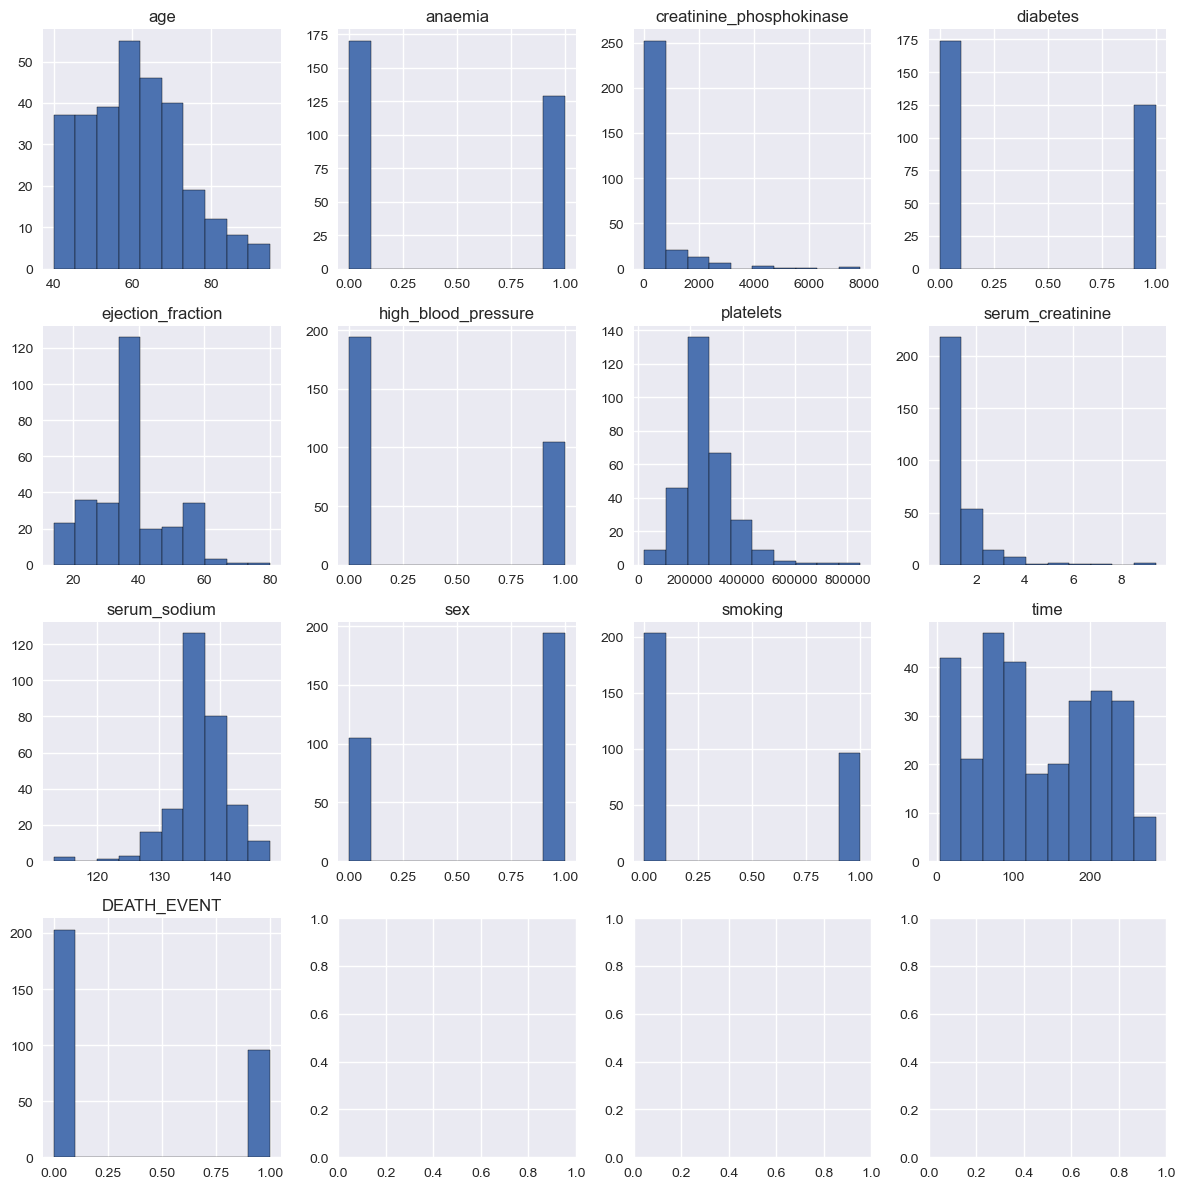

In [494]:
num_rows = 4
num_col = 4

fig, axes = plt.subplots(num_rows, num_col, figsize=(12,12))
for i, column in enumerate(df_wo_outliers_trim.columns):
    row = i // num_cols
    col = i % num_cols
    
    data = df_wo_outliers_trim[column]
    
    axes[row, col].hist(data, bins=10, edgecolor = 'black')
    axes[row, col].set_title(column)
    
plt.tight_layout()
plt.show()

# ML model development

### Dividing the dataset into training and validation samples

In [575]:
x_train, x_valid = train_test_split(
    df.drop("DEATH_EVENT", axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    df["DEATH_EVENT"], train_size=0.7, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 209 rows, 12 cols
x_valid.shape = 90 rows, 12 cols


In [576]:
# Without outliers
x_train_trim, x_valid_trim = train_test_split(
    df_wo_outliers_trim.drop("DEATH_EVENT", axis=1), train_size=0.7, shuffle=True, random_state=1,
)
y_train_trim, y_valid_trim = train_test_split(
    df_wo_outliers_trim["DEATH_EVENT"], train_size=0.7, shuffle=True, random_state=1,
)
print("x_train.shape = {} rows, {} cols".format(*x_train_trim.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid_trim.shape))

x_train.shape = 156 rows, 12 cols
x_valid.shape = 68 rows, 12 cols


In [453]:
# Function for model training and model quality assessment on training and validation samples.
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    estimator.fit(x_train, y_train) 
    y_train_pred = estimator.predict_proba(x_train)[:, 1] 
    y_valid_pred = estimator.predict_proba(x_valid)[:, 1] 

    train_score = roc_auc_score(y_train, y_train_pred) 
    valid_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"Model Score: train = {round(train_score, 4)}, valid = {round(valid_score, 4)}")

    return y_train_pred, y_valid_pred


def plot_validation_curves(train_scores: np.array,
                           valid_scores: np.array,
                           figsize: Tuple[int, int] = (5, 5)):
    
    fig = plt.figure(figsize=figsize)

    #plt.subplot
    plt.title("Validation Curves", size=15)
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(train_scores, axis=1),
        label="train",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1),
        y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1),
        alpha=0.25
    )
    #plt.subplot
    plt.plot(
        range(train_scores.shape[0]),
        np.mean(valid_scores, axis=1),
        label="valid",
        linewidth=3,
        marker="s"
    )
    plt.fill_between(
        x=range(train_scores.shape[0]),
        y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1),
        y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1),
        alpha=0.25
    )
    plt.legend(loc="best", fontsize=14)
    plt.ylabel("roc_auc", size=15)

## Linear model

In [595]:
# Original dataframe
pipeline = Pipeline(
    steps=[
        ("scaling", StandardScaler()),
        ("model", LogisticRegression(random_state=27, C=1e-5)) 
    ]
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    pipeline, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.8967, valid = 0.8726


In [606]:
# TRIMMING outliers

pipeline1 = Pipeline(
    steps=[
        ("scaling", StandardScaler()),
        ("model", LogisticRegression(random_state=27, C=1e-5)) 
    ]
)
y_train_pred_trim, y_valid_pred_trim = fit_evaluate_model(
    pipeline, x_train_trim, y_train_trim, x_valid_trim, y_valid_trim
)

Model Score: train = 0.8706, valid = 0.9594


## Decision tree with maximum depth = 5

In [456]:
# Original dataframe
tree = DecisionTreeClassifier(
    max_depth=5, random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    tree, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9699, valid = 0.7987


In [457]:
# TRIMMING outliers
tree = DecisionTreeClassifier(
    max_depth=5, random_state=27
)
y_train_pred_trim, y_valid_pred_trim = fit_evaluate_model(
    tree, x_train_trim, y_train_trim, x_valid_trim, y_valid_trim)

Model Score: train = 0.9895, valid = 0.8922


## Bagging on decision trees

Original DataFrame

In [577]:
%%time

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=27), random_state=27, n_jobs=2
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    bagging, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9878, valid = 0.8942
CPU times: user 50.9 ms, sys: 42.9 ms, total: 93.8 ms
Wall time: 2.69 s


In [461]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=bagging,
    param_range=[10, 25, 50, 100],
    param_name="n_estimators",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

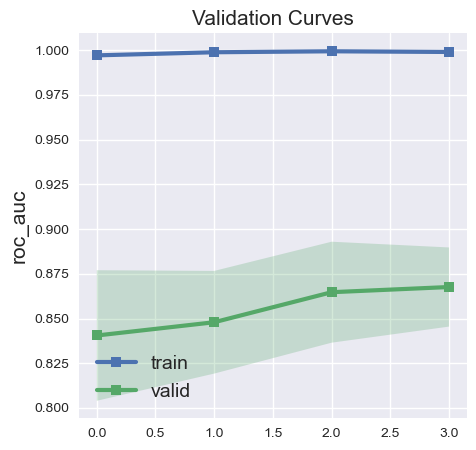

In [463]:
plot_validation_curves(
    train_scores, valid_scores
)

Change __max_depth__ to 10

In [464]:
%%time

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=27), random_state=27, n_jobs=2
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    bagging, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.9983, valid = 0.8801
CPU times: user 30.5 ms, sys: 5.1 ms, total: 35.5 ms
Wall time: 88.4 ms


In [465]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=bagging,
    param_range=[10, 25, 50, 100],
    param_name="n_estimators",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

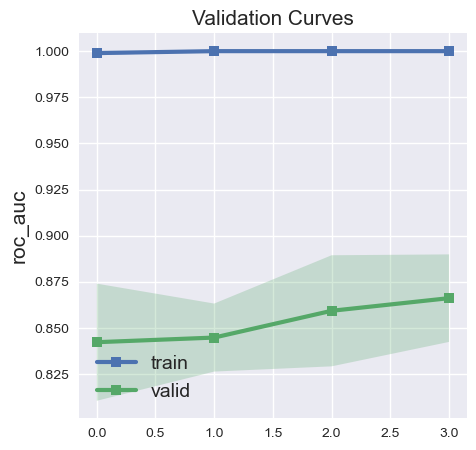

In [466]:
plot_validation_curves(
    train_scores, valid_scores
)

### INTERPRETATION

Increasing the `max_depth` hyperparameter from 5 to 10 in the `DecisionTreeClassifier` within the `BaggingClassifier` has led to changes in the model's performance.

The model with `max_depth=10` achieved a higher __training__ performance with a model score of 0.9977 compared to the previous model with `max_depth=5`, which had a score of 0.988. This indicates that the model with a higher `max_depth` is able to better fit the training data.

__However__, the validation performance of the model with `max_depth=10` decreased slightly, with a model score of 0.8939 compared to the previous model's score of 0.9123. This suggests that the increase in `max_depth` may have caused the model to become more complex and overfit the training data, resulting in reduced generalization ability.

It is important to note that the validation score provides an estimate of how well the model is likely to perform on unseen data. In this case, the model with `max_depth=10` may not generalize as well to new data compared to the model with `max_depth=5`, as indicated by the lower validation score.

TRIMMING outliers

In [578]:
%%time
bagging1 = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=27), random_state=27, n_jobs=2
)
y_train_pred_trim, y_valid_pred_trim = fit_evaluate_model(
    bagging, x_train_trim, y_train_trim, x_valid_trim, y_valid_trim
)

Model Score: train = 0.9958, valid = 0.9234
CPU times: user 41.8 ms, sys: 8.86 ms, total: 50.7 ms
Wall time: 174 ms


In [579]:
bagging1.fit(x_train_trim, y_train_trim)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                   random_state=27),
                  n_jobs=2, random_state=27)

## RANDOM FOREST

In [468]:
# Original DataFrame
forest = RandomForestClassifier(
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 1.0, valid = 0.9222


In [469]:
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=forest,
    param_range=range(2, 15),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

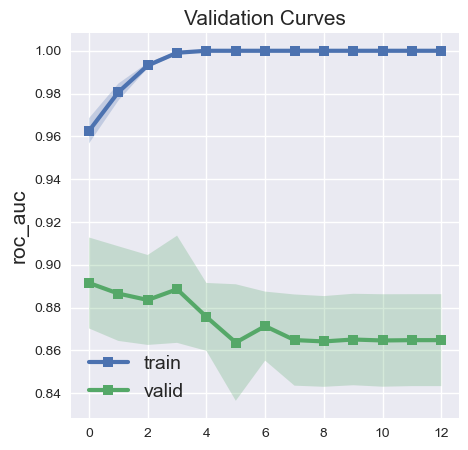

In [470]:
plot_validation_curves(
    train_scores, valid_scores
)

In [471]:
# TRIMMING outliers
forest = RandomForestClassifier(
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train_trim, y_train_trim, x_valid_trim, y_valid_trim
)

Model Score: train = 1.0, valid = 0.9344


In [472]:
train_scores_trim, valid_scores_trim = validation_curve(
    X=x_train_trim,
    y=y_train_trim,
    estimator=forest,
    param_range=range(2, 15),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

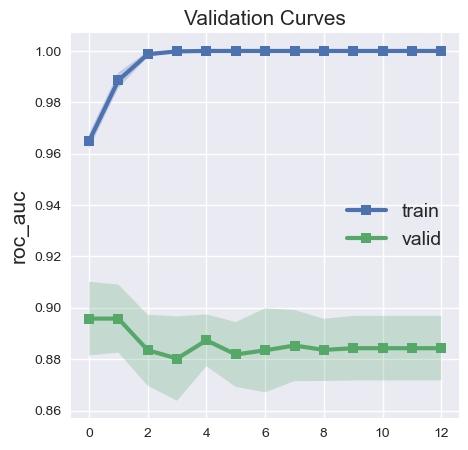

In [473]:
plot_validation_curves(
    train_scores_trim, valid_scores_trim
)

# ML model with selected features

In [109]:
selected_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
x_train, x_valid, y_train, y_valid = train_test_split(
    df[selected_features], df["DEATH_EVENT"], train_size=0.7, shuffle=True, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 209 rows, 5 cols
x_valid.shape = 90 rows, 5 cols


In [110]:
# Linear model
pipeline = Pipeline(
    steps=[
        ("scaling", StandardScaler()),
        ("model", LogisticRegression(random_state=27, C=1e-5)) 
    ]
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    pipeline, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.545, valid = 0.5799


In [111]:
# Random forest 
forest = RandomForestClassifier(
    random_state=27
)
y_train_pred, y_valid_pred = fit_evaluate_model(
    forest, x_train, y_train, x_valid, y_valid
)

Model Score: train = 0.687, valid = 0.5775


### INTERPRETATION

It's seen that as the number of features decreases, the performance of the ML model deteriorates

### Check the quality

In [593]:
df.head(1)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1


In [594]:
df.tail(1)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
298,50.0,0,196,0,45,0,395000.0,1.6,136,1,1,285,0


In [586]:
data_1 = {
'age': [75.0],
'anaemia':[0],
'creatinine_phosphokinase':[582],
'diabetes':[0],
'ejection_fraction' :[20],
'high_blood_pressure':[1],
'platelets':[265000.0],
'serum_creatinine':[1.9],
'serum_sodium' :[130],
'sex':[1],
'smoking':[0],
'time': [4]
}

data_298 = {
'age': [50.0],
'anaemia':[0],
'creatinine_phosphokinase':[196],
'diabetes':[0],
'ejection_fraction' :[45],
'high_blood_pressure':[0],
'platelets':[395000.0],
'serum_creatinine':[1.6],
'serum_sodium' :[136],
'sex':[1],
'smoking':[1],
'time': [285]
}

In [587]:
df_new_1 = pd.DataFrame(data_1)
df_new_1

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4


In [588]:
prediction = bagging1.predict(df_new_1)
print("Prediction for new case:", prediction)

Prediction for new case: [1]


In [590]:
df_new_298 = pd.DataFrame(data_298)
df_new_298

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,50.0,0,196,0,45,0,395000.0,1.6,136,1,1,285


In [610]:
prediction = bagging1.predict(df_new_298)
print("Prediction for new case:", prediction)

Prediction for new case: [0]


In [611]:
prediction = pipeline1.predict(df_new_298) # Linear model using Logistic regression
print("Prediction for new case:", prediction)

Prediction for new case: [0]


In [612]:
prediction = pipeline1.predict(df_new_1) # Linear model using Logistic regression
print("Prediction for new case:", prediction)

Prediction for new case: [0]
